In [3]:
!pip install pytorch-ignite

In [4]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.contrib.handlers import ProgressBar

Total train data: 202
Total test data: 51
Train image at index 0:


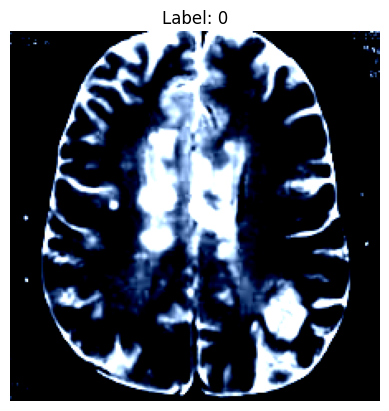

Train image at index 52:


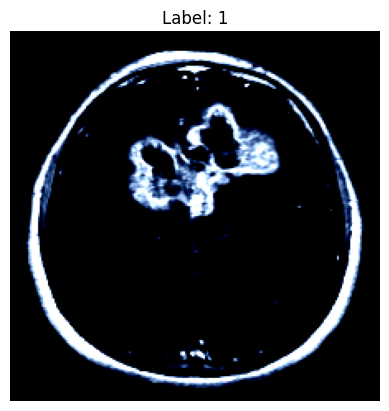

Test image at index 0:


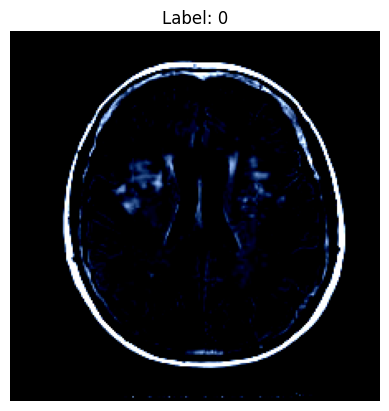

In [5]:
# Base path to your data
base_path = '/content/drive/My Drive/brain_tumor_dataset'  # Replace with your actual base path

# Paths to subfolders
yes_path = os.path.join(base_path, 'yes')
no_path = os.path.join(base_path, 'no')

# Function to load images
def load_image(file_path):
    return np.array(Image.open(file_path))

# Listing files and loading images
yes_files = [os.path.join(yes_path, f) for f in os.listdir(yes_path) if os.path.isfile(os.path.join(yes_path, f))]
no_files = [os.path.join(no_path, f) for f in os.listdir(no_path) if os.path.isfile(os.path.join(no_path, f))]

# Creating labels
yes_labels = [1] * len(yes_files)  # Label '1' for 'yes' class
no_labels = [0] * len(no_files)    # Label '0' for 'no' class

# Merging files and labels
all_files = yes_files + no_files
all_labels = yes_labels + no_labels

# Splitting the data: 80% training, 20% testing
train_files, test_files, train_labels, test_labels = train_test_split(all_files, all_labels, test_size=0.20, random_state=42, stratify=all_labels)

class BrainTumorDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert('RGB')  # Ensure image is in RGB format
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Set the transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = BrainTumorDataset(train_files, train_labels, transform=train_transforms)
test_dataset = BrainTumorDataset(test_files, test_labels, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Check the structure and some examples
print(f"Total train data: {len(train_dataset)}")
print(f"Total test data: {len(test_dataset)}")

# Function to display an image from the dataset
def display_image(dataset, index):
    image, label = dataset[index]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

# Display example images
print("Train image at index 0:")
display_image(train_dataset, 0)

print("Train image at index 52:")
display_image(train_dataset, 52)

print("Test image at index 0:")
display_image(test_dataset, 0)

In [6]:
# Create label mappings
labels = sorted(set(train_labels))
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in id2label.items()}
print("id2label:", id2label)
print("label2id:", label2id)

id2label: {0: 0, 1: 1}
label2id: {0: 0, 1: 1}


Building ViT model from scratch

In [ ]:
class Img2Seq(nn.Module):
    def __init__(self, img_size, patch_size, n_channels, d_model):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.d_model = d_model

        self.n_patches = (img_size // patch_size) ** 2
        self.patch_dim = patch_size * patch_size * n_channels

        self.linear_embedding = nn.Linear(self.patch_dim, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_embedding = nn.Parameter(torch.randn(1, self.n_patches + 1, d_model))

    def forward(self, x):
        B = x.shape[0]
        x = x.view(B, self.n_channels, self.img_size, self.img_size)
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(B, self.n_channels, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).contiguous().view(B, self.n_patches, self.patch_dim)

        x = self.linear_embedding(patches)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding

        return x

def get_mlp(d_model, mlp_head_units, n_classes):
    layers = []
    input_dim = d_model  # Start with the output dimension of the transformer
    for units in mlp_head_units:
        layers.append(nn.Linear(input_dim, units))
        layers.append(nn.ReLU())
        input_dim = units
    layers.append(nn.Linear(input_dim, n_classes))
    return nn.Sequential(*layers)

class ViT(nn.Module):
    def __init__(
        self,
        img_size,
        patch_size,
        n_channels,
        d_model,
        nhead,
        dim_feedforward,
        blocks,
        mlp_head_units,
        n_classes,
    ):
        super().__init__()
        self.img2seq = Img2Seq(img_size, patch_size, n_channels, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward, activation="gelu", batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, blocks
        )
        self.mlp = get_mlp(d_model, mlp_head_units, n_classes)

        self.output = nn.Sigmoid() if n_classes == 1 else nn.Softmax(dim=1)

    def forward(self, batch):
        batch = self.img2seq(batch)
        batch = self.transformer_encoder(batch)
        batch = batch[:, 0, :]
        batch = self.mlp(batch)
        output = self.output(batch)
        return output

# Instantiate the model
img_size = 224
patch_size = 16
n_channels = 3
d_model = 768
nhead = 12
dim_feedforward = 3072
blocks = 12
mlp_head_units = [768, 384]  # Adjusted to ensure dimensions match
n_classes = 2

model = ViT(img_size, patch_size, n_channels, d_model, nhead, dim_feedforward, blocks, mlp_head_units, n_classes)


Total train data: 202
Total test data: 51
Train image at index 0:


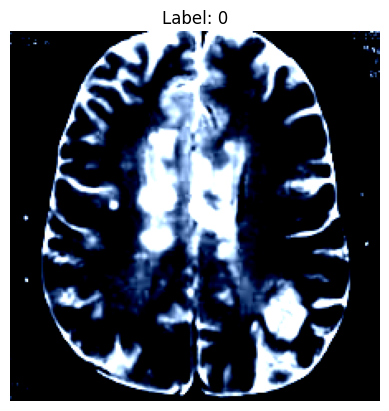

Train image at index 52:


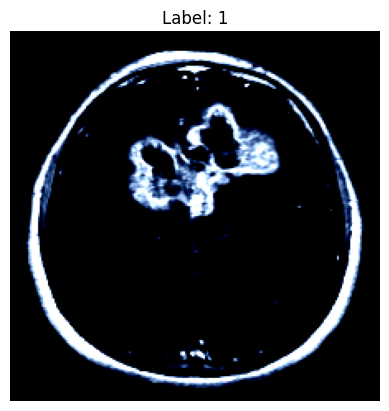

Test image at index 0:


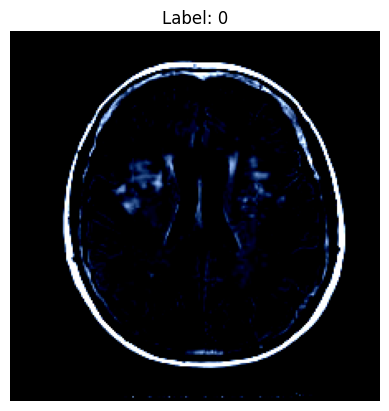

id2label: {0: 0, 1: 1}
label2id: {0: 0, 1: 1}
Epoch 1/20
Train Loss: 0.6760 Acc: 0.5941
Val Loss: 0.6805 Acc: 0.6078
Epoch 2/20
Train Loss: 0.6994 Acc: 0.6139
Val Loss: 0.7053 Acc: 0.6078
Epoch 3/20
Train Loss: 0.6994 Acc: 0.6139
Val Loss: 0.7054 Acc: 0.6078
Epoch 4/20
Train Loss: 0.6994 Acc: 0.6139
Val Loss: 0.7054 Acc: 0.6078
Epoch 5/20
Train Loss: 0.6994 Acc: 0.6139
Val Loss: 0.7054 Acc: 0.6078
Epoch 6/20
Train Loss: 0.6994 Acc: 0.6139
Val Loss: 0.7054 Acc: 0.6078
Epoch 7/20
Train Loss: 0.6993 Acc: 0.6139
Val Loss: 0.7053 Acc: 0.6078
Epoch 8/20
Train Loss: 0.6996 Acc: 0.6139
Val Loss: 0.6956 Acc: 0.6078
Epoch 9/20
Train Loss: 0.6815 Acc: 0.5644
Val Loss: 0.7040 Acc: 0.6078
Epoch 10/20
Train Loss: 0.6991 Acc: 0.6139
Val Loss: 0.7053 Acc: 0.6078
Epoch 11/20
Train Loss: 0.7349 Acc: 0.5743
Val Loss: 0.7054 Acc: 0.6078
Epoch 12/20
Train Loss: 0.6994 Acc: 0.6139
Val Loss: 0.7054 Acc: 0.6078
Epoch 13/20
Train Loss: 0.6994 Acc: 0.6139
Val Loss: 0.7054 Acc: 0.6078
Epoch 14/20
Train Loss: 0.6

In [ ]:
# Training and evaluation functions
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct.double() / len(loader.dataset)
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct.double() / len(loader.dataset)
    return epoch_loss, epoch_acc

# Set device, initialize model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT(img_size, patch_size, n_channels, d_model, nhead, dim_feedforward, blocks, mlp_head_units, n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
best_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_vit_model.pth')

print('Best Val Acc: {:.4f}'.format(best_acc))


Using HuggingFace Pretrained ViT model

In [ ]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomAdjustSharpness,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_data, collate_fn=collate_fn, batch_size=4)
test_dataloader = DataLoader(test_data, collate_fn=collate_fn, batch_size=4)

In [ ]:
!pip install -q evaluate transformers datasets mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.4 MB/s eta 0:00:00


In [ ]:
# imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score,
                             roc_auc_score,
                             confusion_matrix,
                             classification_report,
                             f1_score)

import evaluate
from datasets import Dataset, Image
from transformers import (TrainingArguments,
                          Trainer,
                          ViTImageProcessor,
                          ViTForImageClassification,
                          DefaultDataCollator)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomAdjustSharpness,
                                    Resize,
                                    ToTensor)

253 253


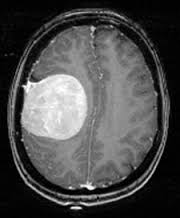

In [ ]:
# use https://huggingface.co/docs/datasets/image_load for reference

image_dict = {}
# Define the list of file names
from pathlib import Path
file_names = []
labels = []
for file in Path('/content/drive/My Drive/brain_tumor_dataset').glob('*/*.*'):
    file_names.append(str(file))
    label = str(file).split('/')[-2]
    labels.append(label)
print(len(file_names), len(labels))

dataset = Dataset.from_dict({"image": file_names, "label": labels}).cast_column("image", Image())
dataset[0]["image"]

In [ ]:
labels = ['no', 'yes']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

{0: 'no', 1: 'yes'} 

 {'no': 0, 'yes': 1}


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 253
})

In [ ]:
dataset = dataset.train_test_split(test_size=0.3)
train_data = dataset['train']
test_data = dataset['test']

In [ ]:
 train_data[52]['label']

'yes'

In [ ]:
model_str = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [ ]:
# Set the transforms
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels))
model.config.id2label = id2label
model.config.label2id = label2id
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.800194


In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    # predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']


    return {
        "accuracy": acc_score
    }

In [ ]:
metric_name = "accuracy"
model_name = "brain_tumor_detection"
num_train_epochs=25
args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1, # save fewer checkpoints to limit used space
    report_to="mlflow",  # log to mlflow
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
trainer.evaluate()

{'eval_loss': 0.7090564370155334,
 'eval_accuracy': 0.35526315789473684,
 'eval_runtime': 84.8581,
 'eval_samples_per_second': 0.896,
 'eval_steps_per_second': 0.224}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.707413,0.368421
2,No log,0.699934,0.434211
3,No log,0.688446,0.592105
4,No log,0.673040,0.671053
5,No log,0.654444,0.789474
6,No log,0.627678,0.828947
7,No log,0.598889,0.828947
8,No log,0.551580,0.881579
9,No log,0.494974,0.894737
10,No log,0.453209,0.894737


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.707413,0.368421
2,No log,0.699934,0.434211
3,No log,0.688446,0.592105
4,No log,0.673040,0.671053
5,No log,0.654444,0.789474
6,No log,0.627678,0.828947
7,No log,0.598889,0.828947
8,No log,0.551580,0.881579
9,No log,0.494974,0.894737
10,No log,0.453209,0.894737


TrainOutput(global_step=150, training_loss=0.37953389485677086, metrics={'train_runtime': 9936.2081, 'train_samples_per_second': 0.445, 'train_steps_per_second': 0.015, 'total_flos': 3.429020540445696e+17, 'train_loss': 0.37953389485677086, 'epoch': 25.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.28787046670913696,
 'eval_accuracy': 0.8947368421052632,
 'eval_runtime': 49.6001,
 'eval_samples_per_second': 1.532,
 'eval_steps_per_second': 0.383,
 'epoch': 25.0}

In [ ]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.28787046670913696, 'test_accuracy': 0.8947368421052632, 'test_runtime': 58.0532, 'test_samples_per_second': 1.309, 'test_steps_per_second': 0.327}


Accuracy: 0.8947
F1 Score: 0.9273


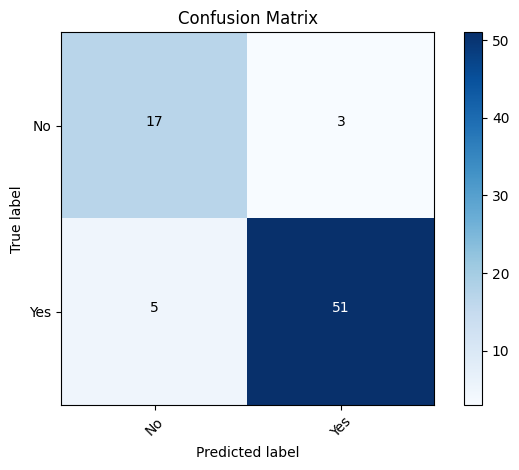

In [ ]:
%matplotlib inline
labels = ["No", "Yes"]
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plot_confusion_matrix(cm, labels)

In [ ]:
trainer.save_model()

In [ ]:
from transformers import pipeline

pipe=pipeline('image-classification',model=model_name)

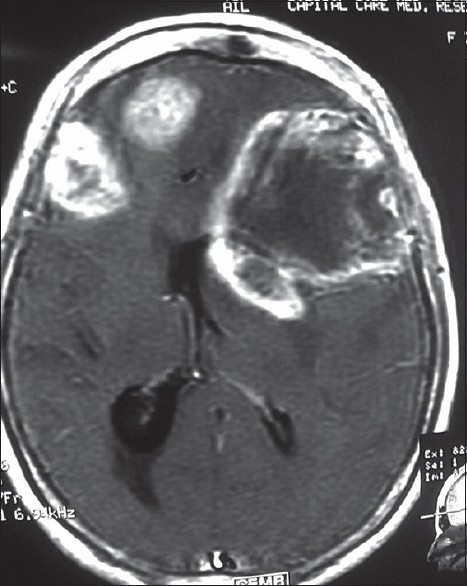

In [ ]:
image = dataset["train"][0]["image"]

image

In [ ]:
print(pipe(image))

[{'label': 'yes', 'score': 0.8793752789497375}, {'label': 'no', 'score': 0.12062475085258484}]


In [ ]:
# actual label
dataset["train"][0]["label"]

'yes'